# Messy Room Classifier

Identify if a picture of a room is considered clean/messy.  
Useful for IoT smart cleaning robots  
... or just proving to your mom that your room is clean.

Resources:  
- https://medium.com/bbm406f18/week-1-clean-messy-rooms-detection-12ff60177103
- https://www.hackster.io/matt-farley/use-artificial-intelligence-to-detect-messy-clean-rooms-f224a2
- https://github.com/GuanqiaoDing/messy-room-classifier
- https://medium.com/bbm406f18/week-2-clean-messy-rooms-322bdcd99de

Dataset:  
- https://www.kaggle.com/cdawn1/messy-vs-clean-room


### Approach
Transfer Learning with **VGG-16** as the base model.  
An average pooling layer, a fully connected layer and a logits layer of 2 classes are added at the end of the base model. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as ply
import pandas as pd

import os, json
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

import tensorflow as tf

### Data Preprocessing
#### Converting raw files in folders into something we can feed into tf.data

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.  
Finally we randomly shuffle them up

In [7]:
def create_df_from_images(path):
    data = []
    for root, dirs, files in os.walk(path, topdown=True):
        for name in files:
            if '.png' not in name:
                continue

            filename = os.path.abspath(os.path.join(root, name))
            class_name = os.path.basename(root)
            data.append((filename, class_name))

    df = pd.DataFrame(data, columns=['filename', 'class_name'])
    df['class_name'] = df['class_name'].astype('category')
    df['class'] = df['class_name'].cat.codes

    # Shuffle
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [8]:
img_width, img_height = 224, 224

train_path = "./images/train/"
validation_data_dir = "./images/val/"

### Define training & validation sets

In [21]:
df_train = create_df_from_images(train_path)
df_val = create_df_from_images(validation_data_dir)

In [43]:
df_train.head()

,filename,class_name,class
0,C:\Pinardy\Projects\messy-room-detection\image...,messy,1
1,C:\Pinardy\Projects\messy-room-detection\image...,messy,1
2,C:\Pinardy\Projects\messy-room-detection\image...,messy,1
3,C:\Pinardy\Projects\messy-room-detection\image...,clean,0
4,C:\Pinardy\Projects\messy-room-detection\image...,messy,1


### Make the pipeline for loading and resizing the images

In [17]:
# Reads an image from a file, decodes it into a tensor, and resizes it to a fixed shape
img_rows, img_cols = 224, 224
num_classes = 2
batch_size = 32

def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string,channels=3)
    image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
    image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
    label = tf.one_hot(label, num_classes)
    return image_resized, label

### Assembling the Data pipeline using tf.data

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [23]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

### Transfer Learning

We will download the VGG network weights

In [24]:
# Create the base pre-trained model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None)

58892288/58889256 [==============================] - 27s 0us/step


In [25]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# Add a logits layer -- 2 classes (messy, clean)
predictions = Dense(2, activation='softmax')(x)

### Training

In [27]:
model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
# Train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [29]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
train_steps = int(192/4) # total trains set / batch_size
val_steps = int(20/4)
epochs = 1

print('train steps:', train_steps)
print('val steps:', val_steps)

train steps: 48
val steps: 5


In [35]:
# Train the model with validation 
history = model.fit(train_dataset, 
                    steps_per_epoch = train_steps,
                    epochs = epochs,
                    validation_data = valid_dataset,
                    validation_steps = val_steps)

Train for 48 steps, validate for 5 steps
48/48 [==============================] - 489s 10s/step - loss: 0.8539 - accuracy: 0.8932 - val_loss: 0.0353 - val_accuracy: 0.9500


### Testing

In [36]:
metrics = model.evaluate(valid_dataset,
                         steps = val_steps)
print("model accuracy:",metrics[1])

5/5 [==============================] - 40s 8s/step - loss: 0.0353 - accuracy: 0.9500
model accuracy: 0.95


### Try it out with your own picture! (Or from the test set)

In [55]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

def predict_cleanliness(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
#     print('Input image shape:', x.shape)
    
    preds = model.predict(x)
    result = preds[0][0]
    if result < preds[0][1]:
        label = "messy"
    else:
        label = "clean"
        
    return "Your room is %s" % label

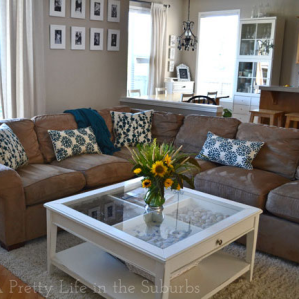

In [60]:
from IPython.display import Image
img_path = './images/test/0.png'
Image(img_path)

In [61]:
predict_cleanliness(img_path)

'Your room is clean'

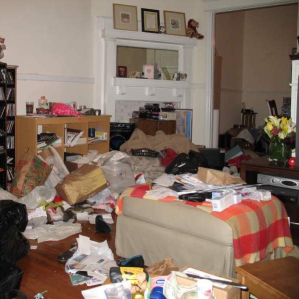

In [62]:
img_path = './images/test/2.png'
Image(img_path)

In [63]:
predict_cleanliness(img_path)

'Your room is messy'

### Save model

In [49]:
model.save('./vgg_model.h5')